<a href="https://colab.research.google.com/github/JayThibs/map-floodwater-drivendata-competition/blob/main/notebooks/jacques_drivendata_map_floodwater_benchmark_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Benchmark and Experimentation Notebook

This notebook follows the benchmark tutorial blog post from the competition. We will be following the tutorial here to get an end-to-end pipeline to get a competition submission, and then we'll start doing our own experimentation on the code. This includes logging and doing hyperparameter sweeps with Weights and Biases.

This notebook has been updated to work with Google Colab. Once we are done with basic experimentation, we will shift over to refactoring the code into scripts so that we can do training runs locally and in Colab (via ngrok: https://www.youtube.com/watch?v=ah_7J0w1Wac).

# Installations

In [1]:
# Installing the pytorch-lightning framework for training the models
!pip install pytorch-lightning==1.4.5 watermark --quiet

# Installing the segmentation_models.pytorch package to get access to pre-trained models
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch --quiet

# model monitoring
!pip install wandb==0.9.7 --quiet

# Path style access for pandas
!pip install pandas_path --quiet

# For interacting with geospatial data
!pip install rasterio --quiet

# For image augmentation during training
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir --quiet

     |████████████████████████████████| 919 kB 9.0 MB/s 
     |████████████████████████████████| 829 kB 64.2 MB/s 
     |████████████████████████████████| 282 kB 81.4 MB/s 
     |████████████████████████████████| 636 kB 79.0 MB/s 
     |████████████████████████████████| 125 kB 94.0 MB/s 
     |████████████████████████████████| 1.3 MB 77.8 MB/s 
     |████████████████████████████████| 160 kB 73.7 MB/s 
     |████████████████████████████████| 271 kB 68.7 MB/s 
     |████████████████████████████████| 58 kB 4.1 MB/s 
     |████████████████████████████████| 376 kB 18.2 MB/s 
     |████████████████████████████████| 1.4 MB 9.8 MB/s 
     |████████████████████████████████| 76 kB 5.9 MB/s 
     |████████████████████████████████| 139 kB 87.2 MB/s 
     |████████████████████████████████| 97 kB 8.0 MB/s 
     |████████████████████████████████| 180 kB 70.5 MB/s 
     |████████████████████████████████| 70 kB 9.7 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████

In [2]:
import pytorch_lightning as pl
import pandas_path
import rasterio
import segmentation_models_pytorch as smp
import wandb
import torch
import albumentations as album
import os
import numpy as np
import pandas as pd
from pytorch_lightning import seed_everything
import random
print(pl.__version__)
print(pandas_path.__version__)
print(rasterio.__version__)
print(smp.__version__)
print(wandb.__version__)
print(torch.__version__)
print(album.__version__)

1.4.5
0.3.0
1.2.10
0.2.0
0.9.7
1.9.0+cu111
1.1.0


In [3]:
%load_ext watermark

In [4]:
%watermark -v

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0



In [5]:
%watermark -i

# 0. Authenticate with Google Drive and W&B

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: ERROR Not authenticated.  Copy a key from https://app.wandb.ai/authorize


API Key: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [8]:
%cd drive/MyDrive/

/content/drive/MyDrive


# 1. Explore The Data

In [9]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# This is where our downloaded images and metadata live locally
DATA_PATH = Path("driven-data-floodwater-mapping-competition")

In [10]:
train_metadata = pd.read_csv(
    DATA_PATH / "flood-training-metadata.csv", parse_dates=["scene_start"]
)

In [11]:
train_metadata.head()

,image_id,chip_id,flood_id,polarization,location,scene_start
0,awc00_vh,awc00,awc,vh,Bolivia,2018-02-15
1,awc00_vv,awc00,awc,vv,Bolivia,2018-02-15
2,awc01_vh,awc01,awc,vh,Bolivia,2018-02-15
3,awc01_vv,awc01,awc,vv,Bolivia,2018-02-15
4,awc02_vh,awc02,awc,vh,Bolivia,2018-02-15


Polarization VV (vertical transmit, vertical receive) means that the light that was sent to Earth was in a vertical polarization and it remained vertical after being reflected and going through clouds, etc. This is not necessarily the case and may change depending on the matter which the light is being reflected off of. The light and end up being polarized in either horizontal, circular-left, and circular-right polarization.

It may also be the case that light which is sent as 100% vertical polarization may come back as x% vertically polarized and y% horizontally polarized. This means that the detectors will detect less intensity in the vertical polarization (compared to what it sent), and the rest is either lost intensity through reflection, absorption or changing to another polarization (or unpolarized).

In [12]:
train_metadata.shape

(1084, 6)

In [13]:
train_metadata.chip_id.nunique() # each unique chip has both vv and vh band (542 * 2 = 1084)

542

In [14]:
flood_counts = train_metadata.groupby("flood_id")["chip_id"].nunique()
flood_counts.describe()

count    13.000000
mean     41.692308
std      19.947367
min      15.000000
25%      28.000000
50%      32.000000
75%      65.000000
max      69.000000
Name: chip_id, dtype: float64

The training data include chips from 13 flood events. We have anywhere from 15 to 69 chips (30 to 138 images) per unique event, with half of events containing fewer than 32 chips (64 images).

In [15]:
location_counts = (
    train_metadata.groupby("location")["chip_id"].nunique().sort_values(ascending=False)
)

Text(0.5, 1.0, 'Number of Chips by Location')

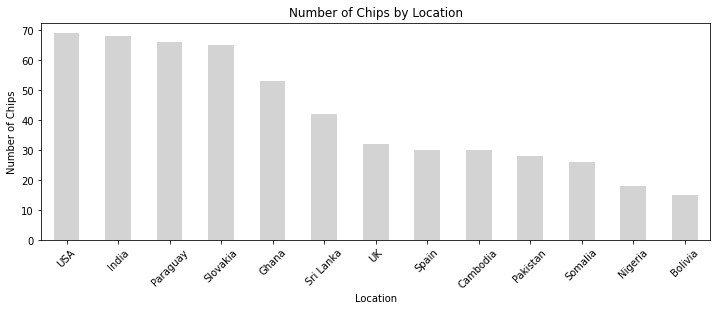

In [16]:
plt.figure(figsize=(12, 4))
location_counts.plot(kind="bar", color="lightgray")
plt.xticks(rotation=45)
plt.xlabel("Location")
plt.ylabel("Number of Chips")
plt.title("Number of Chips by Location")

We have a variety of location that definitely have different types of land, so it will be important to train our models to take that into account and test our models on different locations so that we can find out where needs to be the most improvement.

Some locations have way more chips for floods than others, so that means the data is likely much richer in those areas.

In [17]:
year = train_metadata.scene_start.dt.year
year_counts = train_metadata.groupby(year).nunique()
year_counts

,image_id,chip_id,flood_id,polarization,location,scene_start
scene_start,,,,,,
2016,136,68,1,2,1,1
2017,140,70,2,2,2,2
2018,416,208,6,2,6,6
2019,262,131,3,2,3,3
2020,130,65,1,2,1,1


In [18]:
train_metadata.groupby("flood_id").nunique()

,image_id,chip_id,polarization,location,scene_start
flood_id,,,,,
awc,30,15,2,1,1
ayt,36,18,2,1,1
coz,56,28,2,1,1
hbe,138,69,2,1,1
hxu,52,26,2,1,1
jja,132,66,2,1,1
kuo,130,65,2,1,1
pxs,136,68,2,1,1
qus,60,30,2,1,1


The training data cover flood events that occurred between 2016 and 2020. Images for each event were captured on the same day.

# 2. Loading and Exploring Images

Next, we can begin exploring the image data. We'll add a `feature_path` column to our training metadata, which will contain a `Path` object with the full path to a training image. We'll also add a `label_path` column that points to each image's corresponding water label.

In [19]:
from pandas_path import path

In [20]:
train_metadata.chip_id

0       awc00
1       awc00
2       awc01
3       awc01
4       awc02
        ...  
1079    wvy29
1080    wvy30
1081    wvy30
1082    wvy31
1083    wvy31
Name: chip_id, Length: 1084, dtype: object

In [21]:
train_metadata.chip_id.path.with_suffix(".tif")

0       awc00.tif
1       awc00.tif
2       awc01.tif
3       awc01.tif
4       awc02.tif
          ...    
1079    wvy29.tif
1080    wvy30.tif
1081    wvy30.tif
1082    wvy31.tif
1083    wvy31.tif
Name: chip_id, Length: 1084, dtype: object

In [22]:
list_of_img_paths = list(str(DATA_PATH / "train_labels") / train_metadata.chip_id.path.with_suffix(".tif").path)
list_of_img_paths[:5]

['driven-data-floodwater-mapping-competition/train_labels/awc00.tif',
 'driven-data-floodwater-mapping-competition/train_labels/awc00.tif',
 'driven-data-floodwater-mapping-competition/train_labels/awc01.tif',
 'driven-data-floodwater-mapping-competition/train_labels/awc01.tif',
 'driven-data-floodwater-mapping-competition/train_labels/awc02.tif']

In [23]:
train_metadata["feature_path"] = (
    str(DATA_PATH / "train_features") /
    train_metadata.image_id.path.with_suffix(".tif").path
)

In [24]:
train_metadata["label_path"] = (
    str(DATA_PATH / "train_labels") /
    train_metadata.chip_id.path.with_suffix(".tif").path
)

A GeoTIFF is a raster image file that contains geographic metadata describing the location of the image. This metadata can include bounding coordinates, an affine transform, and a coordinate reference system (CRS) projection. The package [rasterio](https://rasterio.readthedocs.io/en/latest/) makes it easy to interact with our geospatial raster data.

In [25]:
import rasterio

In [26]:
train_metadata.feature_path[0]

'driven-data-floodwater-mapping-competition/train_features/awc00_vh.tif'

In [27]:
# Examine an arbitrary image
image_path = train_metadata.feature_path[0]

In [28]:
with rasterio.open(image_path) as img:
  metadata = img.meta
  bounds = img.bounds
  data = img.read(1) # read a single polarization band

In [29]:
metadata

{'count': 1,
 'crs': CRS.from_epsg(32720),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 512,
 'nodata': 0.0,
 'transform': Affine(10.0, 0.0, 314030.0,
       0.0, -10.0, 8585890.0),
 'width': 512}

In [30]:
bounds

BoundingBox(left=314030.0, bottom=8580770.0, right=319150.0, top=8585890.0)

In [31]:
data

array([[-16.208015 , -17.71951  , -16.281353 , ...,   0.       ,
          0.       ,   0.       ],
       [-15.3288965, -18.231857 , -16.451893 , ...,   0.       ,
          0.       ,   0.       ],
       [-15.353134 , -16.88831  , -15.585904 , ...,   0.       ,
          0.       ,   0.       ],
       ...,
       [-15.741662 , -15.230668 , -13.455255 , ...,   0.       ,
          0.       ,   0.       ],
       [-15.498258 , -14.100984 , -13.11027  , ...,   0.       ,
          0.       ,   0.       ],
       [-16.055603 , -14.1121   , -14.76084  , ...,   0.       ,
          0.       ,   0.       ]], dtype=float32)

We will need to be able to identify pixels with missing data, since we will only be evaluated on predictions made for valid input pixels. The metadata tells us that a value of 0.0 represents missing data for an input image. In rasterio, you can access two different kinds of missing data masks. The first mask is a GDAL-style mask, in which non-zero elements (typically 255) indicate that the corresponding data elements are valid.

In [32]:
with rasterio.open(image_path) as img:
  gdal_mask = img.dataset_mask()

In [33]:
gdal_mask

array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0]], dtype=uint8)

The second mask is a numpy masked array, which has the inverse sense: `True` values indicate that the corresponding data elements are invalid. To load the data as a numpy masked array and access this type of missing data mask, simply pass a `masked` flag to `read`.

In [34]:
with rasterio.open(image_path) as img:
  numpy_mask = img.read(1, masked=True)

In [35]:
numpy_mask

masked_array(
  data=[[-16.20801544189453, -17.71950912475586, -16.281352996826172,
         ..., --, --, --],
        [-15.328896522521973, -18.231857299804688, -16.451892852783203,
         ..., --, --, --],
        [-15.353134155273438, -16.888309478759766, -15.585904121398926,
         ..., --, --, --],
        ...,
        [-15.74166202545166, -15.230668067932129, -13.455254554748535,
         ..., --, --, --],
        [-15.498257637023926, -14.100983619689941, -13.110269546508789,
         ..., --, --, --],
        [-16.05560302734375, -14.112099647521973, -14.76084041595459,
         ..., --, --, --]],
  mask=[[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],
  fill_value=0.0,
  dtype=f

Pixel values represent energy that was reflected back to the satellite measured in decibels. To better visualize the bands or channels of Sentinel-1 images, we will create a [false color composite](https://earthobservatory.nasa.gov/features/FalseColor) by treating the two bands and their ratio as red, grean, and blue channels, respectively. We will prepare a few helper functions to visualize the data.

In [36]:
# import warnings

# warnings.filterwarnings("ignore")

In [37]:
# Helper functions for visualizing Sentinel-1 images
def scale_img(matrix):
    """
    Returns a scaled (H, W, D) image that is visually inspectable.
    Image is linearly scaled between min_ and max_value, by channel.

    Args:
        matrix (np.array): (H, W, D) image to be scaled

    Returns:
        np.array: Image (H, W, 3) ready for visualization
    """
    # Set min/max values
    min_values = np.array([-23, -28, 0.2])
    max_values = np.array([0, -5, 1])

    # Reshape matrix
    w, h, d = matrix.shape
    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)

    # Scale by min/max
    matrix = (matrix - min_values[None, :]) / (
        max_values[None, :] - min_values[None, :]
    )
    matrix = np.reshape(matrix, [w, h, d])

    # Limit values to 0/1 interval
    return matrix.clip(0, 1)


def create_false_color_composite(path_vv, path_vh):
    """
    Returns a S1 false color composite for visualization.

    Args:
        path_vv (str): path to the VV band
        path_vh (str): path to the VH band

    Returns:
        np.array: image (H, W, 3) ready for visualization
    """
    # Read VV/VH bands
    with rasterio.open(path_vv) as vv:
        vv_img = vv.read(1)
    with rasterio.open(path_vh) as vh:
        vh_img = vh.read(1)

    # Stack arrays along the last dimension
    s1_img = np.stack((vv_img, vh_img), axis=-1)

    # Create false color composite
    img = np.zeros((512, 512, 3), dtype=np.float32)
    img[:, :, :2] = s1_img.copy()
    img[:, :, 2] = s1_img[:, :, 0] / s1_img[:, :, 1]

    return scale_img(img)


def display_random_chip(random_state):
    """
    Plots a 3-channel representation of VV/VH polarizations as a single chip (image 1).
    Overlays a chip's corresponding water label (image 2).

    Args:
        random_state (int): random seed used to select a chip

    Returns:
        plot.show(): chip and labels plotted with pyplot
    """
    f, ax = plt.subplots(1, 2, figsize=(9, 9))

    # Select a random chip from train_metadata
    random_chip = train_metadata.chip_id.sample(random_state=random_state).values[0]
    chip_df = train_metadata[train_metadata.chip_id == random_chip]

    # Extract paths to image files
    vv_path = chip_df[chip_df.polarization == "vv"].feature_path.values[0]
    vh_path = chip_df[chip_df.polarization == "vh"].feature_path.values[0]
    label_path = chip_df.label_path.values[0]

    # Create false color composite
    s1_img = create_false_color_composite(vv_path, vh_path)

    # Visualize features
    ax[0].imshow(s1_img)
    ax[0].set_title("S1 Chip", fontsize=14)

    # Load water mask
    with rasterio.open(label_path) as lp:
        lp_img = lp.read(1)

    # Mask missing data and 0s for visualization
    label = np.ma.masked_where((lp_img == 0) | (lp_img == 255), lp_img)

    # Visualize water label
    ax[1].imshow(s1_img)
    ax[1].imshow(label, cmap="cool", alpha=1)
    ax[1].set_title("S1 Chip with Water Label", fontsize=14)

    plt.tight_layout(pad=5)
    plt.show()

Let's inspect a few chips and their water labels.

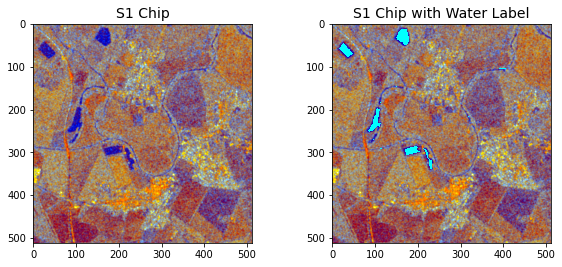

In [38]:
display_random_chip(7)

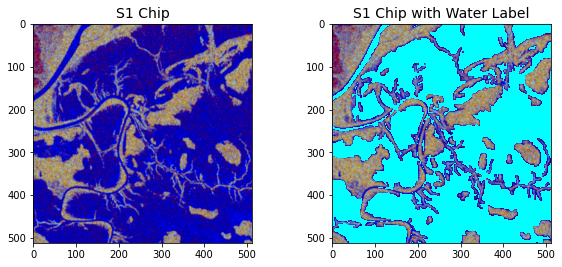

In [39]:
display_random_chip(66)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide


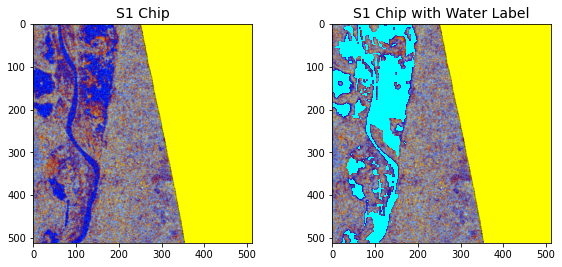

In [40]:
display_random_chip(90)

You'll notice that some images contain high floodwater coverage, while others have little to no coverage. Water spread may be concentrated in one location or spread out, depending on a variety of surface characteristics like topography, terrain, and ground cover. Missing pixels are displayed in yellow.

In [41]:
# Confirming that the images are 512 x 512 pixels.

# examples = [rasterio.open(train_metadata.feature_path[x]) for x in range(len(train_metadata.feature_path))]
# for image in examples:
#     assert image.shape == (512, 512)

# The images are all indeed (512, 512) in shape.
# We are now commenting this code since it takes almost 6 minutes to run and
# we've already answered our question.

# 3. Split the Data

Here we will split the data in a simple way, but if we wanted to really test and improve our model, we would create a set of train/test/validation sets so that we can compare all the models on different slice of data.

In [43]:
seed_everything(9) # set a seed for reproducibility, seeds torch, numpy, python.random

Global seed set to 9


9

In [44]:
# sample 3 random floods for validation set
flood_ids = train_metadata.flood_id.unique().tolist()
val_flood_ids = random.sample(flood_ids, 3)
val_flood_ids

['pxs', 'qxb', 'jja']

In [45]:
val = train_metadata[train_metadata.flood_id.isin(val_flood_ids)]
train = train_metadata[~train_metadata.flood_id.isin(val_flood_ids)]

Since a single input to our model will contain both VV and VH bands, let's identify our input paths by `chip_id`.

In [46]:
# Helper function for pivoting out paths by chip
def get_paths_by_chip(image_level_df):
    """
    Returns a chip-level dataframe with pivoted columns
    for vv_path and vh_path.

    Args:
        image_level_df (pd.DataFrame): image-level dataframe

    Returns:
        chip_level_df (pd.DataFrame): chip-level dataframe
    """
    paths = []
    for chip, group in image_level_df.groupby("chip_id"):
        vv_path = group[group.polarization == "vv"]["feature_path"].values[0]
        vh_path = group[group.polarization == "vh"]["feature_path"].values[0]
        paths.append([chip, vv_path, vh_path])
    return pd.DataFrame(paths, columns=["chip_id", "vv_path", "vh_path"])

In [47]:
# Separate features from labels
val_x = get_paths_by_chip(val)
val_y = val[["chip_id", "label_path"]].drop_duplicates().reset_index(drop=True)

train_x = get_paths_by_chip(train)
train_y = train[["chip_id", "label_path"]].drop_duplicates().reset_index(drop=True)

In [48]:
train_x

,chip_id,vv_path,vh_path
0,awc00,driven-data-floodwater-mapping-competition/tra...,driven-data-floodwater-mapping-competition/tra...
1,awc01,driven-data-floodwater-mapping-competition/tra...,driven-data-floodwater-mapping-competition/tra...
2,awc02,driven-data-floodwater-mapping-competition/tra...,driven-data-floodwater-mapping-competition/tra...
3,awc03,driven-data-floodwater-mapping-competition/tra...,driven-data-floodwater-mapping-competition/tra...
4,awc04,driven-data-floodwater-mapping-competition/tra...,driven-data-floodwater-mapping-competition/tra...
...,...,...,...
361,wvy27,driven-data-floodwater-mapping-competition/tra...,driven-data-floodwater-mapping-competition/tra...
362,wvy28,driven-data-floodwater-mapping-competition/tra...,driven-data-floodwater-mapping-competition/tra...
363,wvy29,driven-data-floodwater-mapping-competition/tra...,driven-data-floodwater-mapping-competition/tra...
364,wvy30,driven-data-floodwater-mapping-competition/tra...,driven-data-floodwater-mapping-competition/tra...


In [49]:
train_y

,chip_id,label_path
0,awc00,driven-data-floodwater-mapping-competition/tra...
1,awc01,driven-data-floodwater-mapping-competition/tra...
2,awc02,driven-data-floodwater-mapping-competition/tra...
3,awc03,driven-data-floodwater-mapping-competition/tra...
4,awc04,driven-data-floodwater-mapping-competition/tra...
...,...,...
361,wvy27,driven-data-floodwater-mapping-competition/tra...
362,wvy28,driven-data-floodwater-mapping-competition/tra...
363,wvy29,driven-data-floodwater-mapping-competition/tra...
364,wvy30,driven-data-floodwater-mapping-competition/tra...


In [50]:
# Confirm approx. 1/3 of images are in the validation set
len(val_x) / (len(val_x) + len(train_x)) * 100

32.47232472324723

The previous cell will depend on our random seed. I used 42 as a random seed and only 11% of the images were in the validation set.

# 4. Build the Model

The goal of our first pass is to build a relatively simple model that takes radar imagery as input and outputs binary masks that indicate which pixels in a scene contain floodwater. Once we test this basic approach, we can attempt to improve our model by adding additional sophistication and complexity. We will use a lightweight PyTorch wrapper called PyTorch Lightning for this benchmark solution.

Rather than train an entire convolutional neural network (CNN) from scratch, we will tune a U-Net model for semantic segmentation. U-Net was first designed in 2015 to localize abnormalities in biomedical images. By applying a variety of data augmentation techniques, it can achieve high performance using relatively small training datasets. U-Net can be broadly thought of as an encoder network followed by a decoder network, where the encoder can be initialized using a pretrained backbone. For this exercise, we will initialize our encoder using ResNet34. ResNet was prepared by Microsoft Research Asia in 2015 and is pretrained on the ImageNet dataset.

First, we will need to read the training data into memory, convert the data to PyTorch tensors, and serve the data to our model in batches. Luckily, the PyTorch Dataset and DataLoader classes make implementing these complex tasks relatively straightforward. A Dataset object allows us to define custom methods for working with the data, and a DataLoader object parallelizes data loading.



In [51]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, lr_scheduler

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import iou
from pytorch_lightning.callbacks import ModelCheckpoint, BackboneFinetuning, QuantizationAwareTraining, ModelPruning, EarlyStopping
from pytorch_lightning.loggers import WandbLogger, TensorBoardLogger

import segmentation_models_pytorch as smp

In [52]:
!nvidia-smi

Wed Oct 13 01:15:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [53]:
class FloodDataset(Dataset):
    """
    Reads in images, transforms pixel values, and serves a
    dictionary containing chip ids, image tensors, and
    label masks (where available).
    """

    def __init__(self, x_paths, y_paths=None, transforms=None):
        self.data = x_paths
        self.label = y_paths
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Loads a 2-channel image from a chip-level dataframe
        img = self.data.loc[idx]
        with rasterio.open(img.vv_path) as vv:
            vv_path = vv.read(1)
        with rasterio.open(img.vh_path) as vh:
            vh_path = vh.read(1)
        x_arr = np.stack([vv_path, vh_path], axis=-1)

        # Min-max normalization
        min_norm = -77
        max_norm = 26
        x_arr = np.clip(x_arr, min_norm, max_norm)
        x_arr = (x_arr - min_norm) / (max_norm - min_norm)

        # Apply data augmentation, if provided
        if self.transforms:
            x_arr = self.transforms(image=x_arr)["image"]
        x_arr = np.transpose(x_arr, [2, 0, 1])

        # Prepare sample dictionary
        sample = {"chip_id": img.chip_id, "chip": x_arr}

        # Load label if available - training only
        if self.label is not None:
            label_path = self.label.loc[idx].label_path
            with rasterio.open(label_path) as lp:
                y_arr = lp.read(1)
            # Apply same data augmentation to label
            if self.transforms:
                y_arr = self.transforms(image=y_arr)["image"]
            sample["label"] = y_arr
            
        return sample



Our custom dataset normalizes input pixel values by applying min-max normalization with a minimum of -77 and a maximum of 26.

To prevent overfitting during training, we'll increase the size of our training data by applying a set of data augmentations to our input, including random cropping, random 90 degree rotations, and horizontal and vertical flipping. The image augmentation library albumentations is a helpful resource for this task.

In [1]:
import albumentations as album

In [2]:
# These transformations will be passed to our model class
training_transformations = album.Compose(
    [
     album.RandomResizedCrop(512, 512, scale=(0.75, 1.0), p=0.5),
     album.RandomRotate90(p=0.5),
     album.HorizontalFlip(p=0.5),
     album.VerticalFlip(p=0.5),
     album.Blur(p=0.5)
    #  album.RandomBrightness(),
    #  album.RandomBrightnessContrast()
    ]
)

In [4]:
training_transformations

Compose([
  RandomResizedCrop(always_apply=False, p=0.5, height=512, width=512, scale=(0.75, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=1),
  RandomRotate90(always_apply=False, p=0.5),
  HorizontalFlip(always_apply=False, p=0.5),
  VerticalFlip(always_apply=False, p=0.5),
  Blur(always_apply=False, p=0.5, blur_limit=(3, 7)),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})



Next, we will create a custom class to define our training loss function and a helper function to calculate our validation metric, Intersection over Union (IOU).

For training, we will use a standard mixture of 50% cross-entropy loss and 50% dice loss, which improves learning when there are unbalanced classes. Since our images tend to contain more non-water than water pixels, this metric should be a good fit. Broadly speaking, cross-entropy loss evaluates differences between predicted and ground truth pixels and averages over all pixels, while dice loss measures overlap between predicted and ground truth pixels and divides a function of this value by the total number of pixels in both images. This custom class will inherit torch.nn.Module, which is the base class for all neural network modules in PyTorch. A lower XEDiceLoss score indicates better performance.

For validation, we will calculate IOU. As a reminder, IOU represents the size of the intersection divided by the size of the union of pixels. A higher IOU indicates better performance.


In [56]:
class XEDiceLoss(nn.Module):
    """
    Computes (0.5 * CrossEntropyLoss) + (0.5 * DiceLoss).
    """

    def __init__(self):
        super().__init__()
        self.xe = nn.CrossEntropyLoss(reduction="none")

    def forward(self, pred, true):
        valid_pixel_mask = true.ne(255) # valid pixel mask

        # Cross-entropy loss
        temp_true = torch.where((true == 255), 0, true) # cast 255 to 0 temporarily
        xe_loss = self.xe(pred, temp_true)
        xe_loss = xe_loss.masked_select(valid_pixel_mask).mean()

        # Dice loss
        pred = torch.softmax(pred, dim=1)[:, 1]
        pred = pred.masked_select(valid_pixel_mask)
        true = true.masked_select(valid_pixel_mask)
        dice_loss = 1 - (2.0 * torch.sum(pred * true)) / (torch.sum(pred + true) + 1e-7)

        return (0.5 * xe_loss) + (0.5 * dice_loss)

In [57]:
def intersection_and_union(pred, true):
    """
    Calculates intersection and union for a batch of images.

    Args:
        pred (torch.Tensor): a tensor of predictions
        true (torch.Tensor): a tensor of labels

    Returns:
        intersection (int): total intersection of pixels
        union (int): total union of pixels
    """
    valid_pixel_mask = true.ne(255) # valid pixel mask
    true = true.masked_select(valid_pixel_mask).to("cpu")
    pred = pred.masked_select(valid_pixel_mask).to("cpu")

    # Intersection and union totals
    intersection = np.logical_and(true, pred)
    union = np.logical_or(true, pred)
    return intersection.sum(), union.sum()

In [58]:
class FloodModel(pl.LightningModule):
    def __init__(self, hparams):
        super(FloodModel, self).__init__()
        self.hparams.update(hparams)
        self.save_hyperparameters()
        # print(self.hparams.get("architecture"))
        self.architecture = self.hparams.get("architecture", "Unet")
        self.backbone = self.hparams.get("backbone", "resnet34")
        self.weights = self.hparams.get("weights", "imagenet")
        self.lr = self.hparams.get("lr", 1e-3)
        self.max_epochs = self.hparams.get("max_epochs", 1000)
        self.min_epochs = self.hparams.get("min_epochs", 6)
        self.patience = self.hparams.get("patience", 6)
        self.num_workers = self.hparams.get("num_workers", 2)
        self.batch_size = self.hparams.get("batch_size", 32)
        self.x_train = train_x
        self.y_train = train_y
        self.x_val = val_x
        self.y_val = val_y
        self.output_path = self.hparams.get("output_path", "model-outputs")
        self.gpu = self.hparams.get("gpu", False)
        self.transform = training_transformations

        # Where final model will be saved
        self.output_path = Path.cwd() / self.output_path
        self.output_path.mkdir(exist_ok=True)

        # Track validation IOU globally (reset each epoch)
        self.intersection = 0
        self.union = 0

        # Instantiate datasets, model, and trainer params
        self.train_dataset = FloodDataset(
            self.x_train, self.y_train, transforms=self.transform
        )
        self.val_dataset = FloodDataset(self.x_val, self.y_val, transforms=None)
        self.model = self._prepare_model()
        self.trainer_params = self._get_trainer_params()

    # Required LightningModule methods

    def forward(self, image):
        # Forward pass through the network
        return self.model(image)

    def training_step(self, batch, batch_idx):
        # Swtich on training mode
        self.model.train()
        # self.model.cuda()
        torch.set_grad_enabled(True)

        # Load images and labels
        x = batch["chip"]
        y = batch["label"].long()

        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)

        # Forward pass
        preds = self.forward(x)

        # Calculate training loss
        criterion = XEDiceLoss()
        xe_dice_loss = criterion(preds, y)

        # Log batch xe_dice_loss
        self.log(
            "xe_dice_loss",
            xe_dice_loss,
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True
        )
        return xe_dice_loss

    def validation_step(self, batch, batch_idx):
        # Switch on evaluation mode
        self.model.eval()
        torch.set_grad_enabled(False)

        # Load images and labels
        x = batch["chip"]
        y = batch["label"].long()
        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)

        # Forward pass & softmax
        preds = self.forward(x)
        preds = torch.softmax(preds, dim=1)[:, 1]
        preds = (preds > 0.5) * 1

        # Calculate validation IOU (global)
        intersection, union = intersection_and_union(preds, y)
        self.intersection += intersection
        self.union += union

        # Log batch IOU
        batch_iou = intersection / union
        self.log(
            "iou", batch_iou, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )

        return batch_iou

    def train_dataloader(self):
        # DataLoader class for training
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True,
        )

    def val_dataloader(self):
        # DataLoader class for training
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=0,
            shuffle=False,
            pin_memory=True,
        )

    def configure_optimizers(self):
        # Define optimizer
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

        # Define Scheduler
        scheduler = lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=0.5, patience=self.patience
        )

        scheduler = {
            "scheduler": scheduler,
            "interval": "epoch",
            "monitor": "val_iou",
        } # logged value to monitor

        return [optimizer], [scheduler]

    def validation_epoch_end(self, outputs):
        # Calculate IOU at the end of epoch
        epoch_iou = self.intersection / self.union

        # Reset metrics before next epoch
        self.intersection = 0
        self.union = 0

        # Saving the model in ONNX format
        # dummy_input = torch.zeros(64, 2, 7, 7, device=self.device)
        # model_filename = f"model_{str(self.global_step).zfill(5)}.onnx"
        # torch.onnx.export(self, dummy_input, model_filename, opset_version=11)
        # wandb.save(model_filename)

        # Log epoch validation IOU
        self.log("val_iou", epoch_iou, on_epoch=True, prog_bar=True, logger=True)
        return epoch_iou

    ## Convenience Methods ##

    def _prepare_model(self):
        cls = getattr(smp, self.architecture)
        model = cls(
           encoder_name=self.backbone,
           encoder_weights=self.weights,
           in_channels=2,
           classes=2,
        )
        if self.gpu:
            model.cuda()
        return model

    def _get_trainer_params(self):
        # Define callback behavior
        checkpoint_callback = ModelCheckpoint(
            dirpath=self.output_path,
            # save_top_k=1,
            monitor="val_iou",
            mode="max",
            verbose=True,
        )
        early_stop_callback = EarlyStopping(
            monitor="val_iou",
            patience=(self.patience * 4),
            mode="max",
            verbose=True,
        )

        # Specify where Tensorboard logs will be saved
        self.log_path = Path.cwd() / self.hparams.get("log_path", "tensorboard-logs")
        self.log_path.mkdir(exist_ok=True)
        logger = TensorBoardLogger(self.log_path, name="driven-data-comp")
        wandb_logger = WandbLogger(project="Driven-Data-Floodwater-Mapping", entity="effective-altruism-techs")

        trainer_params = {
            "callbacks": [checkpoint_callback, early_stop_callback],
            "max_epochs": self.max_epochs,
            "min_epochs": self.min_epochs,
            "default_root_dir": self.output_path,
            "logger": [logger, wandb_logger],
            "gpus": None if not self.gpu else 1,
            "fast_dev_run": self.hparams.get("fast_dev_run", False),
            "num_sanity_val_steps": self.hparams.get("val_sanity_checks", 0),
        }
        return trainer_params

    def fit(self):
        # Set up and fit Trainer object
        self.trainer = pl.Trainer(**self.trainer_params)
        self.trainer.fit(self)

# 5. Train the Model

In [59]:
# Not using anymore. Using yaml file now since it will be 
# easier to do sweeps with scripts and the command-line.

hparams = {
    # Required hparams
    "x_train": train_x,
    "x_val": val_x,
    "y_train": train_y,
    "y_val": val_y,
    # Optional hparams
    "architecture": "Unet",
    "backbone": "efficientnet-b7",
    "weights": "imagenet",
    "lr": 1e-3,
    "min_epochs": 6,
    "max_epochs": 1000,
    "patience": 4,
    "batch_size": 8,
    "num_workers": 3,
    "val_sanity_checks": 0,
    "fast_dev_run": False,
    "output_path": "model-outputs",
    "log_path": "tensorboard_logs",
    "gpu": torch.cuda.is_available(),
}

## Creating yaml file for wandb sweep

In [60]:
# hyperparameters for future sweeps

#  learning-rate:
#    distribution: uniform
#    min: 0
#    max: 0.1
#  batch_size:
#    distribution: q_log_uniform
#    q: 1
#    min: {batch_log_min}
#    max: {batch_log_max}

# early_terminate:
#    type: hyperband
#    s: 2
#    eta: 3
#    max_iter: 27

In [61]:
import yaml
import math

batch_log_min = math.log(8)
batch_log_max = math.log(64)
available_gpu = torch.cuda.is_available()

sweep_yaml = f"""
method: grid
metric:
 name: val_iou
 goal: maximize
parameters:
 architecture: 
   values: ["Unet", "UnetPlusPlus", "MAnet", "DeepLab", "DeepLabV3Plus"]
 backbone: 
   values: ["efficientnet-b2", "efficientnet-b4", "efficientnet-b6", "resnet34", "resnet50", "resnet101", "xception"]
 weights: 
   value: imagenet
 optimizer: 
   value: adam
 lr:
   value: 0.001
 batch_size: 
   value: 32
 min_epochs: 
   value: 6
 max_epochs: 
   value: 30
 patience: 
   value: 4
 val_sanity_checks: 
   value: 0
 fast_dev_run: 
   value: False
 output_path: 
   value: model-outputs
 gpu: 
   value: True
 num_workers: 
   value: 0
"""

with open('initial_grid_sweep.yaml', 'w') as file:
    yaml.dump(sweep_yaml, file, default_style='|')

In [62]:
import yaml

with open("initial_grid_sweep.yaml", 'r') as file:
    sweep_string = yaml.safe_load(file)

sweep_config = yaml.safe_load(sweep_string)

In [63]:
sweep_config.get('parameters').get('architecture').get('name')

In [64]:
# sweep_config['parameters']['x_train'] = train_x
# sweep_config['parameters']['x_val'] = val_x
# sweep_config['parameters']['y_train'] = train_y
# sweep_config['parameters']['y_val'] = val_y

In [65]:
# sweep_config.get('parameters').get('y_val').head()

## Init loggers for training

In [66]:
# Only use when not running a sweep
wandb.init(project="Driven-Data-Floodwater-Mapping", entity="effective-altruism-techs")

wandb: Wandb version 0.12.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


W&B Run: https://app.wandb.ai/effective-altruism-techs/Driven-Data-Floodwater-Mapping/runs/17i4oy43

We create sweep id based on our configuration.

In [67]:
# sweep_id = wandb.sweep(sweep_config, project="Driven-Data-Floodwater-Mapping", entity="effective-altruism-techs")

## Instantiate and Fit Model

In [68]:
def sweep_iteration():
    # set up W&B logger
    wandb.init()    # required to have access to `wandb.config`
    wandb_logger = WandbLogger()

    # print(wandb.config)

    # instantiate model - note how we refer to sweep parameters with wandb.config
    flood_model = FloodModel(hparams=wandb.config)

    # setup Trainer
    trainer = pl.Trainer(
        logger=wandb_logger,
        gpus=-1
    )

    # train
    trainer.fit(flood_model)

    wandb.watch(flood_model)

    print(wandb.config)
    print(flood_model.trainer_params["callbacks"][0].best_model_score)

We run an agent that will iterate over the sweep parameters.

In [69]:
# wandb.agent(sweep_id, function=sweep_iteration)

In [70]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [71]:
flood_model = FloodModel(hparams=hparams) # for training one model

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth


  0%|          | 0.00/254M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory /content/drive/My Drive/model-outputs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


In [72]:
wandb.watch(flood_model) # for training one model

In [73]:
flood_model.fit() # for training one model

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: WARNING Serializing object of type DataFrame that is 115816 bytes
wandb: WARNING Serializing object of type DataFrame that is 115816 bytes
wandb: Wandb version 0.12.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

  | Name  | Type | Params
-------------------------------
0 | model | Unet | 67.1 M
-------------------------------
67.1 M    Trainable params
0         Non-trainable params
67.1 M    Total params
268.380   Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:323: UserWarning: The number of training samples (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batch

Training: -1it [00:00, ?it/s]

RuntimeError: ignored

In [ ]:
flood_model.trainer_params["callbacks"][0].best_model_score

In [ ]:
best_model_path = flood_model.trainer_params["callbacks"][0].best_model_path
print(best_model_path)

In [76]:
# flood_model.test()

In [ ]:
# wandb.finish()

In [77]:
best_model = FloodModel(hparams=hparams)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory /content/drive/My Drive/model-outputs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


In [78]:
best_model = best_model.load_from_checkpoint(best_model_path)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory /content/drive/My Drive/model-outputs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


In [79]:
with open(os.path.join('model.pth'), 'wb') as f:
    torch.save(best_model.state_dict(), f)

## Model Inference

In [82]:
class FloodModelInference(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.architecture = "Unet" # os.environ['MODEL_ARCHITECTURE']
        self.backbone = "resnet34"
        cls = getattr(smp, self.architecture)
        self.model = cls(
           encoder_name=self.backbone,
           encoder_weights=None,
           in_channels=2,
           classes=2,
        )

    def forward(self, image):
        # Forward pass
        return self.model(image)

    def predict(self, vv_path, vh_path):
        # Switch on evaluation mode
        self.model.eval()
        torch.set_grad_enabled(False)

        # Create a 2-channel image
        with rasterio.open(vv_path) as vv:
            vv_img = vv.read(1)
        with rasterio.open(vh_path) as vh:
            vh_img = vh.read(1)
        x_arr = np.stack([vv_img, vh_img], axis=-1)

        # Min-max normalization
        min_norm = -77
        max_norm = 26
        x_arr = np.clip(x_arr, min_norm, max_norm)
        x_arr = (x_arr - min_norm) / (max_norm - min_norm)

        # Transpose
        x_arr = np.transpose(x_arr, [2, 0, 1])
        x_arr = np.expand_dims(x_arr, axis=0)

        # Perform inference
        preds = self.forward(torch.from_numpy(x_arr))
        preds = torch.softmax(preds, dim=1)[:, 1]
        preds = (preds > 0.5) * 1
        return preds.detach().numpy().squeeze().squeeze()

In [83]:
vv_path = '/content/drive/MyDrive/driven-data-floodwater-mapping-competition/train_features/awc06_vv.tif'
vh_path = '/content/drive/MyDrive/driven-data-floodwater-mapping-competition/train_features/awc06_vh.tif'
label_path = '/content/drive/MyDrive/driven-data-floodwater-mapping-competition/train_labels/awc06.tif'

In [84]:
label_path

'/content/drive/MyDrive/driven-data-floodwater-mapping-competition/train_labels/awc06.tif'

In [85]:
val_x.vv_path[6]

'driven-data-floodwater-mapping-competition/train_features/jja06_vv.tif'

In [88]:
inference_model = FloodModelInference()
inference_model = inference_model.load_from_checkpoint(checkpoint_path=best_model_path)
results = inference_model.predict(vv_path, vh_path)

In [89]:
results

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [90]:
with open(os.path.join('model.pt'), 'wb') as f:
    torch.save(inference_model.state_dict(), f)

In [91]:
inference_model_test = FloodModelInference()
with open(os.path.join('model.pt'), 'rb') as f:
    inference_model_test.load_state_dict(torch.load(f))

In [92]:
results = inference_model_test.predict(vv_path, vh_path)
print(results)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 1 ... 1 0 0]
 [0 0 1 ... 1 0 0]
 [0 0 0 ... 0 0 0]]


In [93]:
import itertools
flat_list = list(itertools.chain(*results))

count = 0
count_0 = 0
for item in flat_list:
    if item == 1:
        count += 1
    else:
        count_0 += 1 

In [94]:
print(count)
print(count_0)

141844
120300


## Display Result in RGB Image

In [113]:
num = 10
vv_path = val_x.vv_path[num]
vh_path = val_x.vh_path[num]
label_path = val_y.label_path[num]

In [114]:
label_path

'driven-data-floodwater-mapping-competition/train_labels/jja10.tif'

In [115]:
from sklearn.metrics import jaccard_score

def process_mask(mask):
    mask_temp = mask.copy()
    mask_temp[mask == 255] = 0
    return mask_temp


def plot_preds(vv_path=vv_path, vh_path=vh_path, label_path=label_path):
    
    with rasterio.open(vv_path) as fvv:
        vv = fvv.read(1)
    with rasterio.open(vh_path) as fvh:
        vh = fvh.read(1)
    with rasterio.open(label_path) as fmask:
        mask = fmask.read(1)
                
    mask = process_mask(mask)
    
    X = np.zeros((512, 512, 2))
    X[:, :, 0] = (vh - (-17.54)) / 5.15
    X[:, :, 1] = (vv - (-10.68)) / 4.62
    
    prediction = inference_model_test.predict(vv_path, vh_path)
    
    _, ax = plt.subplots(1, 3, figsize=(16, 4))
    ax[0].imshow(X[:, :, 0])
    ax[0].set_title('vh')
    ax[1].imshow(mask)
    ax[1].set_title('gt')
    ax[2].imshow(prediction)
    ax[2].set_title('pred')
    plt.suptitle(jaccard_score(mask.flatten(), prediction.flatten()))
    plt.show()

In [116]:
import matplotlib
matplotlib.__version__

'3.2.2'

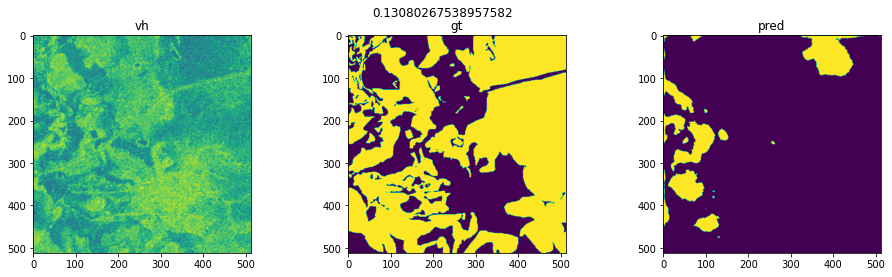

In [117]:
plot_preds()

# 6. Prepare for Submission

## 6.1. Create a local `benchmark-pytorch/` directory 

Add a `benchmark-pytorch/assets` subdirectory to store our trained model and weights.

In [ ]:
# Create directory and subdirectory

submission_path = Path("benchmark-pytorch")
submission_path.mkdir(exist_ok=True)
submission_assets_path = submission_path / "assets"
submission_assets_path.mkdir(exist_ok=True)

In Pytorch, the learnable parameters of a model including its weights and biases are contained in it's parameters. A `state_dict` is a Python dictionary object that maps each layer to its parameter tensor. PyTorch provides a handy `model.save()` method for serializing our model's `state_dict` and, in turn, saving our model's weights.

In [ ]:
# Save trained model and weights

weight_path = submission_assets_path / "flood_model.pt"
torch.save(flood_model.state_dict(), weight_path)

## 6.2. Create Model Class for Inference and `main.py` to Perform Inference

We'll be performing inference on the images sotred in `data/test_features`, generate chip-level predictions, and save predictions to `submission/`.

To load our trained model in the competition runtime environment, we'll save a simplified `FloodModel` class to `benchmark-pytorch/flood_model.py`. This model class will instantiate a generic U-Net model and will contain a helper method to perform inference for a given chip.

Let's start by creating a script with our PyTorch Lightning model so that we can import it in `main.py` and use it for inference.

In [ ]:
%%file benchmark-pytorch/flood_model.py
import numpy as np
import pytorch_lightning as pl
import rasterio
import segmentation_models_pytorch as smp
import torch


class FloodModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = smp.Unet(
            encoder_name="resnet34",
            encoder_weights=None,
            in_channels=2,
            classes=2,
        )

    def forward(self, image):
        # Forward pass
        return self.model(image)

    def predict(self, vv_path, vh_path):
        # Switch on evaluation mode
        self.model.eval()
        torch.set_grad_enabled(False)

        # Create a 2-channel image
        with rasterio.open(vv_path) as vv:
            vv_img = vv.read(1)
        with rasterio.open(vh_path) as vh:
            vh_img = vh.read(1)
        x_arr = np.stack([vv_img, vh_img], axis=-1)

        # Min-max normalization
        min_norm = -77
        max_norm = 26
        x_arr = np.clip(x_arr, min_norm, max_norm)
        x_arr = (x_arr - min_norm) / (max_norm - min_norm)

        # Transpose
        x_arr = np.transpose(x_arr, [2, 0, 1])
        x_arr = np.expand_dims(x_arr, axis=0)

        # Perform inference
        preds = self.forward(torch.from_numpy(x_arr))
        preds = torch.softmax(preds, dim=1)[:, 1]
        preds = (preds > 0.5) * 1
        return preds.detach().numpy().squeeze().squeeze()

Writing benchmark-pytorch/flood_model.py


Now, let's create our `main.py` file to do inference and save our predictions.

This `main.py` file will be placed in the root of our `benchmark-pytorch/` directory since that is what is needed when we package everything to do inference and submit it for a containerized execution. In other words, we aren't simply doing inference on a set of downloaded images; we are saving our model and inference scripts and submitting that in order to do inference.

In [ ]:
%%file benchmark-pytorch/main.py
import os
from pathlib import Path

from loguru import logger
import numpy as np
from tifffile import imwrite
from tqdm import tqdm
import torch
import typer

from flood_model import FloodModel


ROOT_DIRECTORY = Path("/codeexecution")
SUBMISSION_DIRECTORY = ROOT_DIRECTORY / "submission"
ASSETS_DIRECTORY = ROOT_DIRECTORY / "assets"
DATA_DIRECTORY = ROOT_DIRECTORY / "data"
INPUT_IMAGES_DIRECTORY = DATA_DIRECTORY / "test_features"

# Make sure the smp loader can find our torch assets because we don't have internet!
os.environ["TORCH_HOME"] = str(ASSETS_DIRECTORY / "torch")


def make_prediction(chip_id, model):
    """
    Given a chip_id, read in the vv/vh bands and predict a water mask.

    Args:
        chip_id (str): test chip id

    Returns:
        output_prediction (arr): prediction as a numpy array
    """
    logger.info("Starting inference.")
    try:
        vv_path = INPUT_IMAGES_DIRECTORY / f"{chip_id}_vv.tif"
        vh_path = INPUT_IMAGES_DIRECTORY / f"{chip_id}_vh.tif"
        output_prediction = model.predict(vv_path, vh_path)
    except Exception as e:
        logger.error(f"No bands found for {chip_id}. {e}")
        raise
    return output_prediction


def get_expected_chip_ids():
    """
    Use the test features directory to see which images are expected.
    """
    paths = INPUT_IMAGES_DIRECTORY.glob("*.tif")
    # Return one chip id per two bands (VV/VH)
    ids = list(sorted(set(path.stem.split("_")[0] for path in paths)))
    return ids


def main():
    """
    For each set of two input bands, generate an output file
    using the `make_predictions` function.
    """
    logger.info("Loading model")
    # Explicitly set where we expect smp to load the saved resnet from just to be sure
    torch.hub.set_dir(ASSETS_DIRECTORY / "torch/hub")
    model = FloodModel()
    model.load_state_dict(torch.load(ASSETS_DIRECTORY / "flood_model.pt"))

    logger.info("Finding chip IDs")
    chip_ids = get_expected_chip_ids()
    if not chip_ids:
        typer.echo("No input images found!")
        raise typer.Exit(code=1)

    logger.info(f"Found {len(chip_ids)} test chip_ids. Generating predictions.")
    for chip_id in tqdm(chip_ids, miniters=25):
        output_path = SUBMISSION_DIRECTORY / f"{chip_id}.tif"
        output_data = make_prediction(chip_id, model).astype(np.uint8)
        imwrite(output_path, output_data, dtype=np.uint8)

    logger.success(f"Inference complete.")


if __name__ == "__main__":
    typer.run(main)

Writing benchmark-pytorch/main.py


In [ ]:
!cp -R ~/.cache/torch benchmark-pytorch/assets/

In [ ]:
!tree benchmark-pytorch/

/bin/bash: tree: command not found


In [ ]:
# Remember to avoid including the inference dir itself
!cd benchmark-pytorch && zip -r ../submission.zip *

  adding: assets/ (stored 0%)
  adding: assets/flood_model.pt (deflated 7%)
  adding: assets/torch/ (stored 0%)
  adding: assets/torch/hub/ (stored 0%)
  adding: assets/torch/hub/checkpoints/ (stored 0%)
  adding: assets/torch/hub/checkpoints/resnet34-333f7ec4.pth (deflated 7%)
  adding: flood_model.py (deflated 58%)
  adding: main.py (deflated 57%)


In [ ]:
!du -h submission.zip

164M	submission.zip
